In [68]:
# IMPORTS
import glob, os, sys, h5py
import numpy as np
sys.path.insert(0,'../../')
sys.path.insert(0,'/Library/TeX/texbin/')
sys.path.insert(0,'../../WaveformAnalysis')
sys.path.insert(0,'/home/tb829/project/purity-monitor/WaveformAnalysis/')
from scipy.signal import find_peaks, find_peaks_cwt, peak_widths, peak_prominences
from natsort import natsorted
from scipy.optimize import curve_fit
from multiprocessing import Pool, Manager

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 100

def rebin(hx,h,bins):
    bins = int(bins)
    h_rebin=[]
    for i in range(int(len(h)/bins)):
        start_idx=i*bins
        end_idx=(i+1)*bins
        h_rebin.append(np.sum(h[start_idx:end_idx]))
    hx_rebin=range(len(h_rebin))
    return np.array(hx_rebin), np.array(h_rebin)

def gauss(x,a,mu,sigma): return (a*np.exp(-0.5*((x-mu)/sigma)**2))

def line(x,a,b): return a*(x-b)

In [69]:
#FILE = r'/Users/tizi/Documents/YALE_WL.nosync/data/20220812/4Vpp/0.5kHz/mca_keith_30.00OV_0.h5'
#FILE = r'/Users/tizi/Documents/YALE_WL.nosync/data/20220810/4.0Vpp/0.5kHz/mca_keith_30.00OV_0.h5'
FILE = r'/Users/tizi/Documents/YALE_WL.nosync/data/20220812/4Vpp_3min_0.2V_intervals/0.5kHz/mca_keith_30.00OV_0.h5'

f = h5py.File(FILE, 'r')  
ch2 = f.get('ch2')
for key in ch2.keys(): 
    df = np.array(ch2.get(key))
h = df
hx = np.arange(0,len(h),1)

In [70]:
def perm_run(p,x,y,min_peaks,max_error,trials, plot=False): # False if it fails, 
    
    best_index = None
    
    bins = p[0]
    prominence = p[1]
    distance = 500/bins

    try:
        x1, y1 = rebin(x,y,bins)

        pks, pdict = find_peaks(y1,prominence=prominence,distance=distance)

        if len(pks) < min_peaks or len(pks) == 0: return False

        if plot: plt.scatter([pks],[y1[pks]],20,'red','*')

        x2 = np.flip(x1)
        y2 = np.flip(y1)
        flat_end = np.argwhere(y2 > 2)[0][0]
        x2 = x2[flat_end:]
        y2 = y2[flat_end:]
        x1 = np.flip(x2)
        y1 = np.flip(y2)

        if plot: plt.plot(x1,y1)
        #plt.show()

        cumulative = 0
        fitted = []
        fitted_errs = []

        for ii in np.arange(0,len(pks),1):
            tolerance = 0.2
            y_cut = y1

            while len(find_peaks(y_cut,prominence=prominence,distance=distance)[0]) > 1 and tolerance < 0.8:
                index = pks[ii]

                peak_lx, peak_rx = None, None
                try: peak_lx = int(index - np.argwhere(np.flip(y1[:index]) < tolerance*y1[index])[0][0]*1.1)
                except: peak_lx = pdict['left_bases'][ii]
                try: peak_rx = int((index + np.argwhere(y1[index:] < tolerance*y1[index])[0][0])*1.1)
                except: peak_rx = pdict['right_bases'][ii]

                x_cut = x1[int(peak_lx):peak_rx]
                y_cut = y1[int(peak_lx):peak_rx]

                if len(find_peaks(y_cut,prominence=prominence)[0]) > 1: tolerance += 0.05

            if np.abs(np.abs(index-peak_lx) - np.abs(peak_rx-index)) > np.abs(index-peak_lx)*0.2:
                peak_rx = index + np.abs(index-peak_lx)
                x_cut = x1[int(peak_lx):peak_rx]
                y_cut = y1[int(peak_lx):peak_rx]

            sigma = np.abs(int(index - np.argwhere(np.flip(y1[:index]) < 0.5*y1[index])[0][0]))

            try:popt, pcov = curve_fit(gauss,x_cut,y_cut,p0=[y1[index],np.abs(index-peak_lx),sigma],maxfev=10000000)
            except Exception as e: continue
            
            perr = np.sqrt(np.diag(pcov))[1]
            if perr > max_error: continue       # will skip this peak fit due to the error being too large
            cumulative += perr

            fitted.append(popt[1])
            fitted_errs.append(perr)
            cumulative += perr

        cumulative = cumulative/len(pks)

        lowest_comb = 1000
        popt, pcov, perr = None, None, None
        total_selected = None
        index_selected = None
        gain_selected = None
        perr_selected = None

        for ii in np.arange(len(fitted),min_peaks-1,-1):
            for yy in np.arange(0,len(fitted)-ii+1,1):
                peaks = fitted[yy:yy+ii]
                perrs = fitted_errs[yy:yy+ii]

                try: popt,pcov = curve_fit(line,np.arange(1,len(peaks)+1),peaks,maxfev=100000,sigma=perrs)
                except: continue
                perr = np.sqrt(np.diag(pcov))[1]
                comb = perr/ii
                if comb < lowest_comb:
                    lowest_comb = comb
                    total_selected = ii
                    index_selected = yy
                    gain_selected = popt[0]
                    perr_selected = perr
        if total_selected is None: return False

        trials[p] = {'fitted':fitted,'fitted_errs':fitted_errs,'low_comb':lowest_comb,'total_sel':total_selected,'index_sel':index_selected,'gain_sel':gain_selected,'perr_sel':perr_selected,'cumulative':cumulative}

    except Exception as e:
        print(e)
        return False
        

In [80]:
def plot_run(p,x,y,min_peaks,max_error, plot=True): # False if it fails, 
    
    bins = p[0]
    prominence = p[1]
    distance = 500/bins

    try:
        x1, y1 = rebin(x,y,bins)

        pks, pdict = find_peaks(y1,prominence=prominence,distance=distance)

        if len(pks) < min_peaks or len(pks) == 0: return False

        if plot: plt.scatter([pks],[y1[pks]],20,'red','*')

        x2 = np.flip(x1)
        y2 = np.flip(y1)
        flat_end = np.argwhere(y2 > 2)[0][0]
        x2 = x2[flat_end:]
        y2 = y2[flat_end:]
        x1 = np.flip(x2)
        y1 = np.flip(y2)

        plt.subplot(1,2,1)
        plt.plot(x1,y1)
        #plt.show()

        cumulative = 0
        fitted = []
        fitted_errs = []

        for ii in np.arange(0,len(pks),1):
            tolerance = 0.2
            y_cut = y1

            while len(find_peaks(y_cut,prominence=prominence,distance=distance)[0]) > 1 and tolerance < 0.8:
                index = pks[ii]

                peak_lx, peak_rx = None, None
                try: peak_lx = int(index - np.argwhere(np.flip(y1[:index]) < tolerance*y1[index])[0][0]*1.1)
                except: peak_lx = pdict['left_bases'][ii]
                try: peak_rx = int((index + np.argwhere(y1[index:] < tolerance*y1[index])[0][0])*1.1)
                except: peak_rx = pdict['right_bases'][ii]

                x_cut = x1[int(peak_lx):peak_rx]
                y_cut = y1[int(peak_lx):peak_rx]

                if len(find_peaks(y_cut,prominence=prominence)[0]) > 1: tolerance += 0.05

            if np.abs(np.abs(index-peak_lx) - np.abs(peak_rx-index)) > np.abs(index-peak_lx)*0.2:
                peak_rx = index + np.abs(index-peak_lx)
                x_cut = x1[int(peak_lx):peak_rx]
                y_cut = y1[int(peak_lx):peak_rx]

            sigma = np.abs(int(index - np.argwhere(np.flip(y1[:index]) < 0.5*y1[index])[0][0]))

            try:popt, pcov = curve_fit(gauss,x_cut,y_cut,p0=[y1[index],np.abs(index-peak_lx),sigma],maxfev=10000000)
            except Exception as e: continue
            
            perr = np.sqrt(np.diag(pcov))[1]
            if perr > max_error:       # will skip this peak fit due to the error being too large
                plt.plot(x1[peak_lx:peak_rx],gauss(x1[peak_lx:peak_rx],*popt),color='red')
                plt.vlines(fitted,0,50,colors=['blue'],linestyles='dotted')
                plt.scatter([pks[ii]],[y1[pks[ii]]],30,'magenta','*')
            else:
                plt.plot(x1[peak_lx:peak_rx],gauss(x1[peak_lx:peak_rx],*popt),color='lime')
                plt.vlines(fitted,0,50,colors=['blue'],linestyles='dotted')
                plt.scatter([pks[ii]],[y1[pks[ii]]],30,'red','*')

            fitted.append(popt[1])
            fitted_errs.append(perr)
            cumulative += perr

        cumulative = cumulative/len(pks)

        plt.subplot(1,2,2)
        lowest_comb = 1000
        popt, pcov, perr = None, None, None
        total_selected = None
        index_selected = None
        gain_selected = None
        perr_selected = None

        for ii in np.arange(len(fitted),min_peaks-1,-1):
            for yy in np.arange(0,len(fitted)-ii+1,1):
                peaks = fitted[yy:yy+ii]
                perrs = fitted_errs[yy:yy+ii]
                x_data = np.arange(1,len(peaks)+1)

                try: popt,pcov = curve_fit(line,x_data,peaks,maxfev=100000,sigma=perrs)
                except: continue
                perr = np.sqrt(np.diag(pcov))[1]
                comb = perr/ii
                if comb < lowest_comb:
                    lowest_comb = comb
                    total_selected = ii
                    index_selected = yy
                    gain_selected = popt[0]
                    perr_selected = perr
        if total_selected is None: raise Exception()

        peaks = np.asarray(fitted[index_selected:index_selected+total_selected])*bins
        perrs = np.asarray(fitted_errs[index_selected:index_selected+total_selected])*bins
        x_data = np.arange(1,len(peaks)+1)
        popt,pcov = curve_fit(line,x_data,peaks,maxfev=100000,sigma=perrs)
        perr = np.sqrt(np.diag(pcov))[1]
        plt.scatter(x_data, peaks,30,'slateblue')
        plt.plot(x_data,line(x_data,*popt),'--',label=f'Gain {popt[0]:0.2f} $\pm$ {perr}')
        plt.suptitle(f'Gain {popt[0]:0.2f} $\pm$ {perr}')

    except Exception as e:
        print(e)
        plt.clf()
        return False
    plt.show()

In [81]:
def rebin(hx,h,bins):
    bins = int(bins)
    h_rebin=[]
    for i in range(int(len(h)/bins)):
        start_idx=i*bins
        end_idx=(i+1)*bins
        h_rebin.append(np.sum(h[start_idx:end_idx]))
    hx_rebin=range(len(h_rebin))
    return np.array(hx_rebin), np.array(h_rebin)

In [82]:
#x, y = rebin(hx,h,40)
x,y = hx, h

In [83]:
pind, pdict = find_peaks(y, prominence=2000)
print(pind)
print(pdict)

[325]
{'prominences': array([77289.]), 'left_bases': array([0]), 'right_bases': array([737])}


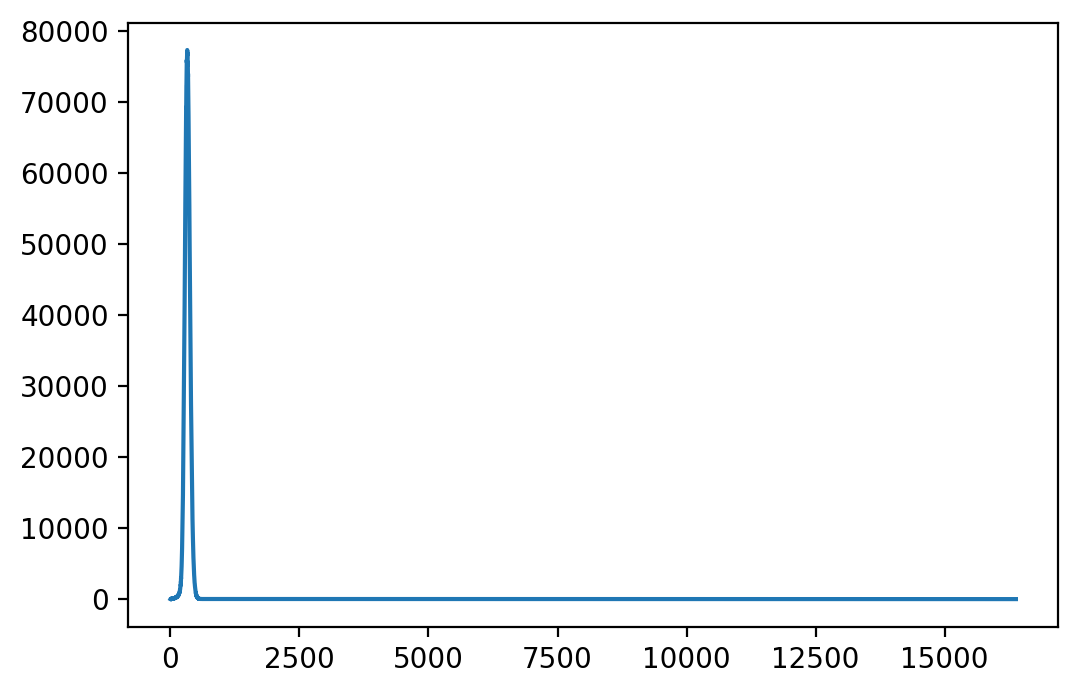

/var/folders/09/wlr8_btn6v58hj13p66lktx00000gn/T/ipykernel_14209/224828688.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.vlines(np.asarray([pind,lix_ind,rix_ind]),0,pdict['prominences'].max(),colors=['red'])


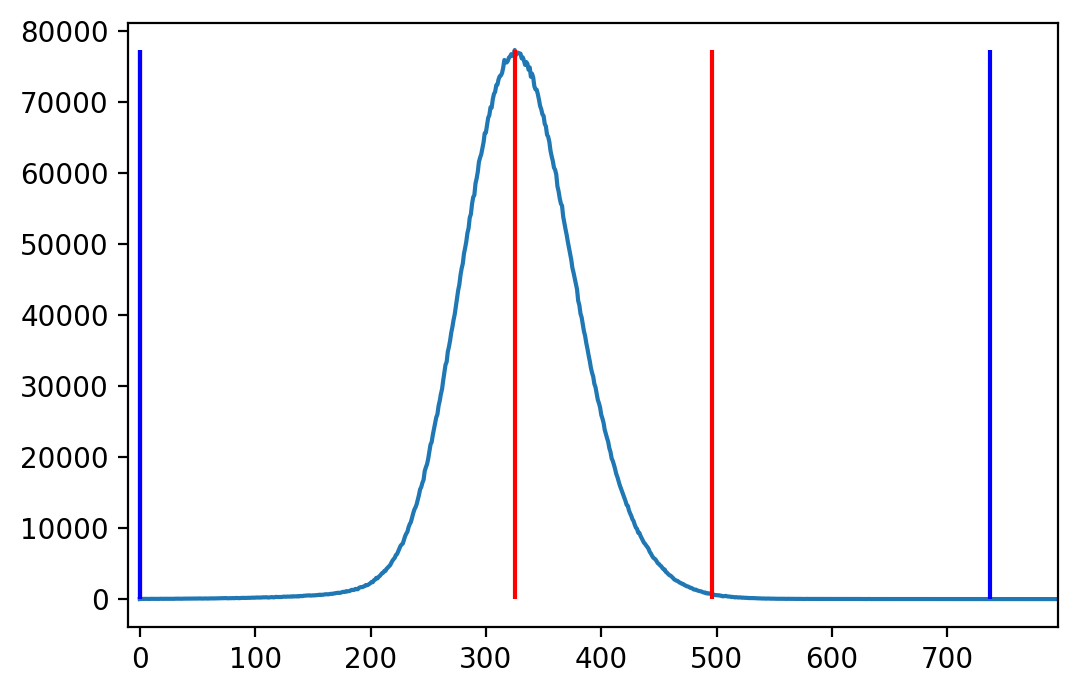

In [84]:
mpl.rcParams['figure.dpi']= 200
plt.plot(x,y)
plt.show()
plt.plot(x,y)

rix_ind = 0
lix_ind = 0
rix_ind_ar = x[int(pind):][y[int(pind):] <= pdict['right_bases']]
if len(rix_ind_ar) == 0: rix_ind = (len(x)-1)
else: rix_ind = rix_ind_ar[0]
lix_ind_ar = x[:int(pind)][y[:int(pind)] <= pdict['left_bases']]
if len(lix_ind_ar) == 0: lix_ind = 0
else: lix_ind = lix_ind_ar[0]

plt.vlines(np.asarray([pind,lix_ind,rix_ind]),0,pdict['prominences'].max(),colors=['red'])
plt.vlines(np.asarray([pdict['left_bases'],pdict['right_bases']]),0,pdict['prominences'].max(),colors=['blue'])
plt.xlim(lix_ind-10,rix_ind+300)
plt.show()

In [85]:
def gauss(x,a,mu,sigma): return (a*np.exp(-0.5*((x-mu)/sigma)**2))

In [86]:
x = x[int(pdict['right_bases']):]
y = y[int(pdict['right_bases']):]

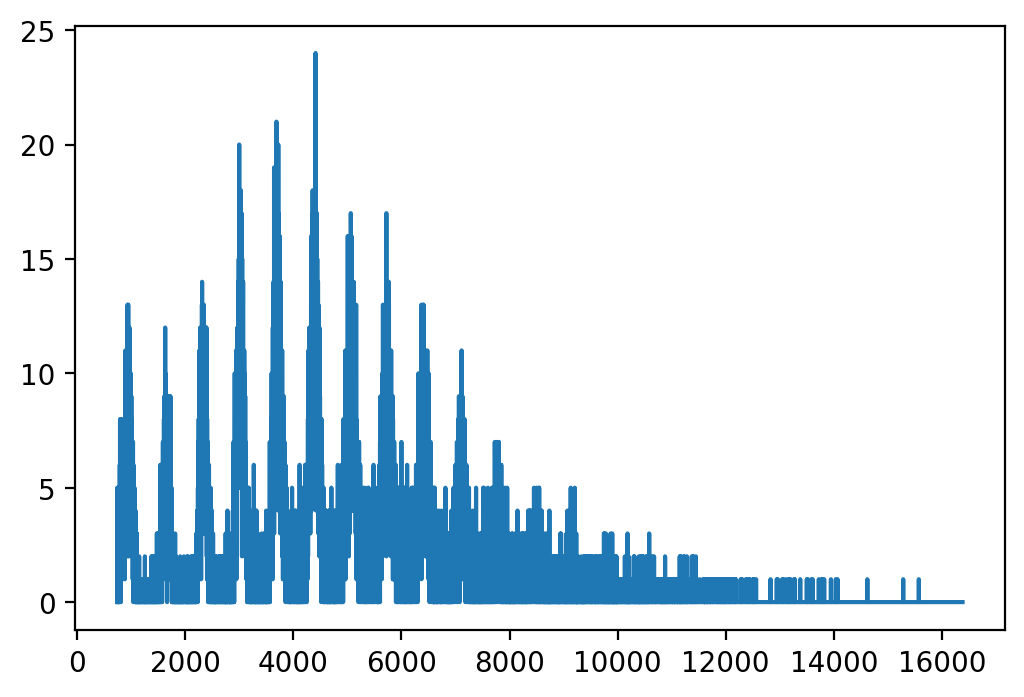

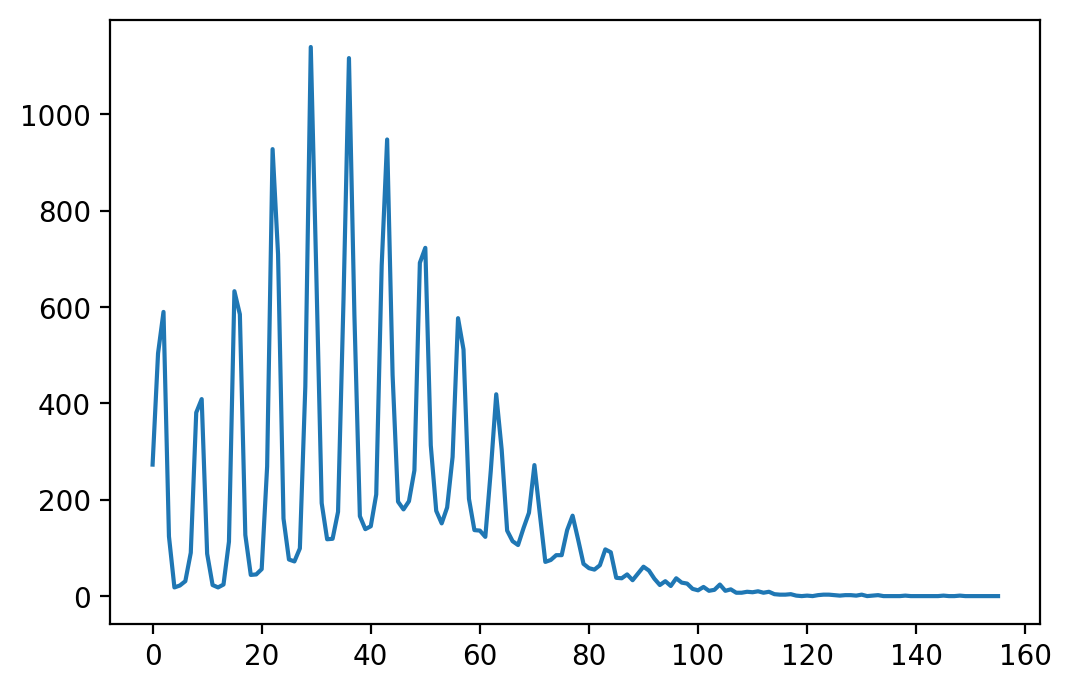

In [87]:
plt.plot(x,y)
plt.show()

x1, y1 = rebin(x,y,100)
plt.plot(x1,y1)
plt.show()

1058


IntProgress(value=0, bar_style='info', description='Loading MCA perms...', layout=Layout(width='100%'), max=10…

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Selected (43, 40) for 5349.207188178891 best quality!


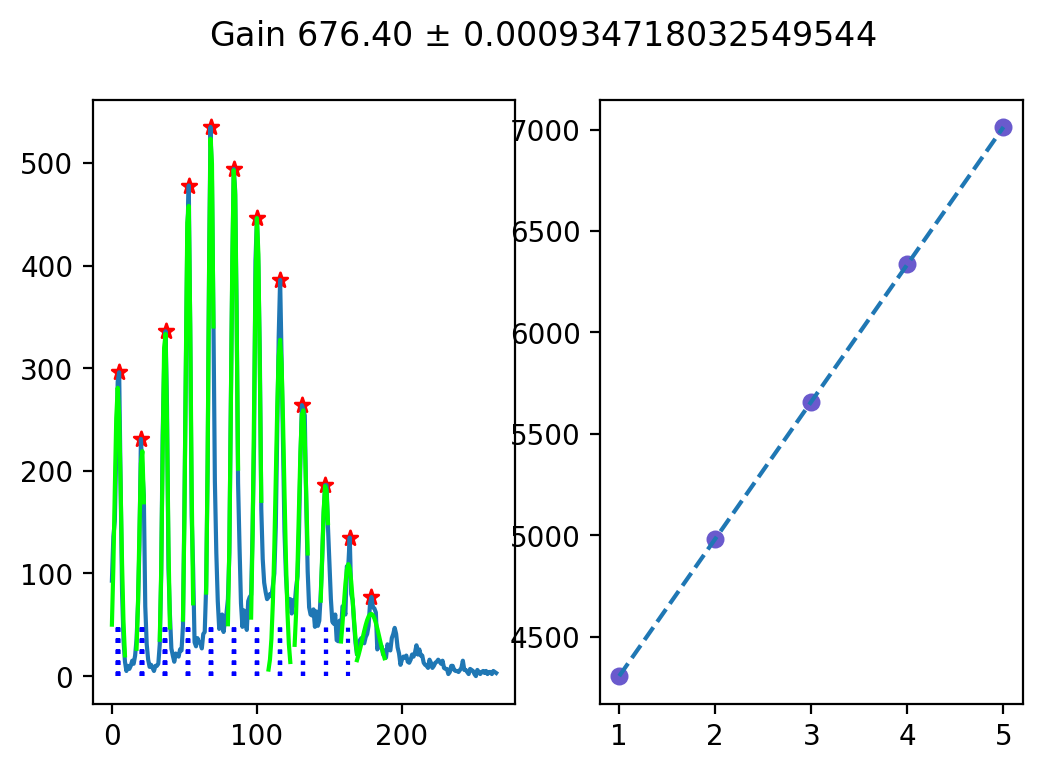

SystemExit: 

/Users/tizi/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [88]:
from ipywidgets import IntProgress
from IPython.display import display
import itertools

bin_start = 5
bin_stop = 50
bin_step = 2 #  DO NOT SET THIS TO FLOAT VALUES --> REBIN ONLY TAKES INTS AND CONVERTS TO INT ANYWAY!!!!!!

prominence_start = 8
prominence_stop = 100
prominence_step = 2

distance_start = 5
distance_stop = 50
distance_step = 2
#1250/bins

min_peaks = 5
max_error = 1.0

perms = [item for item in itertools.product(np.arange(bin_start, bin_stop,bin_step),np.arange(prominence_start, prominence_stop,prominence_step))]

print(len(perms))

f = IntProgress(value=0,min=0,max=len(perms),step=1,description='Loading MCA perms...',bar_style='info',layout={"width": "100%"})
display(f)

"""with Manager() as manager:
    trials = manager.dict()
    args = []

    for perm in perms:
        args.append([perm, x,y,min_peaks,max_error,trials])

    pool = Pool()
    pool.starmap(perm_run, args)
    pool.close()"""

trials = {}
for perm in perms:
    f.value += 1
    perm_run(perm,x,y,min_peaks,max_error,trials)

#{'fitted':fitted,'fitted_errs':fitted_errs,'low_comb':lowest_comb,'total_sel':total_selected,'index_sel':index_selected,'gain_sel':gain_selected,'perr_sel':perr_selected,'cumulative':cumulative}
fits_obtained = {}
    
for p in trials.keys():
    fitted_peaks = trials[p]['fitted']
    fitted_sigmas = trials[p]['fitted_errs']
    lowest_comb_value = trials[p]['low_comb']
    total_selected = trials[p]['total_sel']
    index_selected = trials[p]['index_sel']
    gain_selected = trials[p]['gain_sel']
    sigma_selected = trials[p]['perr_sel']
    cumulative_error = trials[p]['cumulative']

    fit_quality = total_selected/sigma_selected
    fits_obtained[fit_quality] = p

best_fit_quality = np.max([*fits_obtained])
best_fit_perm = fits_obtained[best_fit_quality]
print(f'Selected {best_fit_perm} for {best_fit_quality} best quality!')
plot_run(best_fit_perm,x,y,min_peaks,max_error,True)
sys.exit()
final_peaks = []
final_perrs = []

if best is None: print('Method failed')
else:
    bins = best[0]
    prominence = best[1]
    distance = 800/bins
    x1, y1 = rebin(x,y,bins)

    pks, pdict = find_peaks(y1,prominence=prominence,distance=distance)

    x2 = np.flip(x1)
    y2 = np.flip(y1)
    flat_end = np.argwhere(y2 > 2)[0][0]
    x2 = x2[flat_end:]
    y2 = y2[flat_end:]
    x1 = np.flip(x2)
    y1 = np.flip(y2)
    plt.clf()
    plt.subplot(1,2,1)
    plt.plot(x1,y1)
    fitted = []
    for ii in np.arange(0,len(pks),1):
        tolerance = 0.2
        y_cut = y1
        #print()
        while len(find_peaks(y_cut,prominence=prominence,distance=distance)[0]) > 1 and tolerance < 0.8:
            index = pks[ii]
            #peak_lx = pdict['left_bases'][ii]
            #peak_rx = pdict['right_bases'][ii]
            peak_lx, peak_rx = None, None
            try: peak_lx = int(index - np.argwhere(np.flip(y1[:index]) < tolerance*y1[index])[0][0]*1.1)
            except: peak_lx = pdict['left_bases'][ii]
            try: peak_rx = int((index + np.argwhere(y1[index:] < tolerance*y1[index])[0][0])*1.1)
            except: peak_rx = pdict['right_bases'][ii]
            x_cut = x1[int(peak_lx):peak_rx]
            y_cut = y1[int(peak_lx):peak_rx]
            #print(f'{ii+1}/{len(pks)} L {peak_lx}, R: {peak_rx}')

            #plt.plot(x_cut,y_cut,color='magenta',lw=0.8)
            if len(find_peaks(y_cut,prominence=prominence)[0]) > 1:
                #print('Too many peaks in cut')
                tolerance += 0.05
                continue
            #print(f'{ii+1}/{len(pks)} L {peak_lx}, R: {peak_rx}')
            #print(peak_widths(y1,pks,rel_height=5)[0][ii])

        if np.abs(np.abs(index-peak_lx) - np.abs(peak_rx-index)) > np.abs(index-peak_lx)*0.2:
            peak_rx = index + np.abs(index-peak_lx)
            print(f'Fixing right base... -> L {peak_lx}, R: {peak_rx}')
            x_cut = x1[int(peak_lx):peak_rx]
            y_cut = y1[int(peak_lx):peak_rx]
            #plt.plot(x_cut,y_cut,color='blue',lw=0.8)

        try:sigma = np.abs(int(index - np.argwhere(np.flip(y1[:index]) < 0.5*y1[index])[0][0]))
        except: sigma = np.abs(index-peak_lx)*0.5

        try:popt, pcov = curve_fit(gauss,x_cut,y_cut,p0=[y1[index],np.abs(index-peak_lx),sigma],maxfev=10000000)
        except Exception as e:
            print(e)
            continue
        perr = np.sqrt(np.diag(pcov))[1]
        print(popt,' ',perr)
        final_peaks.append(popt[1])
        final_perrs.append(perr)
        if np.sqrt(np.diag(pcov))[1] > max_error:
            #plt.show()
            continue
        counter += 1
        fitted.append(ii)
        perr = np.sqrt(np.diag(pcov))[1]
        plt.plot(x_cut,gauss(x_cut,*popt),color='lime')
        #plt.show()
    for ftd in fitted:
        plt.scatter([pks[ftd]],[y1[pks[ftd]]],30,'red','*')

    distances = []
    sorted_peaks = np.sort(pks)
    for i in np.arange(2,len(sorted_peaks),1):
        #prev = np.abs(sorted_peaks[i-1]-sorted_peaks[i-2])
        #curr = np.abs(sorted_peaks[i]-sorted_peaks[i-1])
        distances.append(np.abs(sorted_peaks[i]-sorted_peaks[i-1]))
    print(distances)

    plt.vlines([peak_lx,peak_rx,index],0,y1[index],colors=['red'],linestyles='dashed')
    plt.plot(x1[peak_lx:peak_rx],gauss(x1[peak_lx:peak_rx],*popt),color='lime')
    plt.vlines(final_peaks,0,50,colors=['blue'],linestyles='dotted')
    #plt.xlim(0,250)
    #plt.show()
    print(final_peaks)
    print(final_perrs)
    print(best)

def line(x,a,b): return a*(x-b)
x3, y3 = rebin(x,y,best[0])

lowest = 1000
index = 0
plt.subplot(1,2,2)

for ii in np.arange(0,len(final_peaks)-3):
    peaks = final_peaks[ii:ii+4]
    perrs = final_perrs[ii:ii+4]
    popt,pcov = curve_fit(line,np.arange(1,5),peaks,maxfev=100000)
    perr = np.sqrt(np.diag(pcov))[1]
    print(ii, ' ', popt,' ', perr)
    if perr < lowest:
        lowest = perr
        index = ii

print(f'Best peaks are peaks {index} to {index+3}')

peaks = np.asarray(final_peaks[index:index+4])*best[0]
perrs = np.asarray(final_perrs[index:index+4])*best[0]
popt,pcov = curve_fit(line,np.arange(1,5),peaks,maxfev=100000)
plt.plot(np.arange(1,5),line(np.arange(1,5),*popt))
#plt.scatter(np.arange(1,5),peaks,10)
plt.errorbar(np.arange(1,5),peaks,yerr=perrs,fmt='o',ms=7,)
plt.show()
print(perrs)
print(f'Gain {popt[0]} and sigma {np.sqrt(np.diag(pcov))[1]}')